In [56]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class AutoEncoderNN:
    def __init__(
        self, train_X, train_Y, test_X, test_Y, 
        n_input=None, n_output=None, learning_rate=0.001, n_iterations=1000, beta=0.0001,
        n_hidden_layers=2, n_nodes_per_layer=[256, 256], batch_size=128, display_step=100,
        activation=tf.nn.sigmoid, image_dataset = False
    ):       
        self.trainX = train_X
        self.trainY = train_Y
        self.testX = test_X
        self.testY = test_Y
        
        self.n_instances = self.trainX.shape[0]
        self.n_features = self.trainX.shape[1]
        self.n_classes = self.trainY.shape[1]

        # setting initial parameters
        self.n_input = n_input if n_input is not None else self.n_features
        self.n_output = n_output if n_output is not None else self.n_classes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.n_layers = n_hidden_layers
        # self.n_nodes_per_layer = n_nodes_per_layer
        self.batch_size = batch_size
        self.display_step = display_step
        
        self.image_dataset = image_dataset
        
        self.beta = beta  # parameter for L2 loss
        
        self._epochs_completed = 0
        self._index_in_epoch = 0
        
        # compute initial weights and biases for all layers
        self.wt, self.b = self._generate_initial_weights(n_nodes_per_layer)
        
        # graph placeholders
        self.X = tf.placeholder("float", [None, self.n_input])
        self.Y = tf.placeholder("float", [None, self.n_output])
        
        # perceptron and output perceptron computation
        self.perceptron = lambda h, w, b: activation(tf.add(tf.matmul(h, w), b))
#         self.output_perceptron = lambda h, w, b: output_activation(tf.add(tf.matmul(h, w), b))

        print("="*30)
        print('# of neurons in each layer: {}'.format(n_nodes_per_layer))
        print("="*30)
        
    
    def _generate_initial_weights(self, n_nodes_per_layer):
        weights = dict()
        biases = dict()
        prev_layer_n_output = self.n_input
        for i in range(self.n_layers):
            weights.update({
                'encode_{}'.format(i+1): tf.Variable(tf.random_normal([prev_layer_n_output, n_nodes_per_layer[i]])),
                'decode_{}'.format(self.n_layers-i): tf.Variable(tf.random_normal([n_nodes_per_layer[i], prev_layer_n_output]))
            })
            biases.update({
                'encode_{}'.format(i+1): tf.Variable(tf.random_normal([n_nodes_per_layer[i]])),
                'decode_{}'.format(self.n_layers-i): tf.Variable(tf.random_normal([prev_layer_n_output]))
            })
            prev_layer_n_output = n_nodes_per_layer[i]        
        return weights, biases
    
    def next_batch(self, X, Y, batch_size=None):
        """Return the next `batch_size`. Generalizes TF's internal implementation"""
        _x = X
        _y = Y
        batch_size = self.batch_size if batch_size is None else batch_size
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > len(_x):
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(len(_x))
            np.random.shuffle(perm)
            _x = _x[perm]
            _y = _y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= len(_x)
        end = self._index_in_epoch
        return _x[start:end], _y[start:end]
    
    def network(self, x, task=None):
        _p = self.perceptron
        assert task.lower() in ['encode', 'decode']
        
        layer_outputs = []
        previous_layer_output = x
        for i in range(self.n_layers):
            previous_layer_output = _p(previous_layer_output, self.wt['{}_{}'.format(task, i+1)], self.b['{}_{}'.format(task, i+1)])
            layer_outputs.append(previous_layer_output)
        return layer_outputs[-1]
    
    def optimize(self):
        decoder_op = self.network(self.network(self.X, 'encode'), 'decode')
        # Prediction
        y_pred = decoder_op
        # Targets (Labels) are the input data.
        y_true = self.X
        # Define loss and optimizer, minimize the squared error
        loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(loss)
        
        sess = tf.Session()
        # Run the initializer
        sess.run(tf.global_variables_initializer())
        
        
        # Training
        for i in range(1, self.n_iterations+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, batch_y = self.next_batch(self.trainX, self.trainY)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, l = sess.run([optimizer, loss], feed_dict={self.X: batch_x})
            # Display logs per step
            if i % self.display_step == 0 or i == 1:
                print('Step %i: Minibatch Loss: %f' % (i, l))
                
        self.print_image_testing(sess, decoder_op) if self.image_dataset else self.print_general_testing(sess, decoder_op)
        return l
    
    def print_image_testing(self, sess, decoder_op):
        n = 4
        canvas_orig = np.empty((28 * n, 28 * n))
        canvas_recon = np.empty((28 * n, 28 * n))
        for i in range(n):
            batch_x, batch_y = self.next_batch(self.testX, self.testY, batch_size=n)
            g = sess.run(decoder_op, feed_dict={self.X: batch_x})
#             print(batch_x.shape, g.shape)
            for j in range(n):
                canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
            for j in range(n):
                canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

        print('-'*15)
        print("Original Images")     
        plt.figure(figsize=(n, n))
        plt.imshow(canvas_orig, origin="upper")
        plt.show()

        print('-'*15)
        print("Reconstructed Images")
        plt.figure(figsize=(n, n))
        plt.imshow(canvas_recon, origin="upper")
        plt.show()

    def print_general_testing(self, sess, decoder_op):
        n = 4
        for i in range(n):
            batch_x, batch_y = self.next_batch(self.testX, self.testY, batch_size=n)
            g = sess.run(decoder_op, feed_dict={self.X: batch_x})
            print(batch_x.shape, g.shape)
            diff = np.abs(np.subtract(batch_x, g))
            print('Absolute difference between original and reconstructed values (sorted in decreasing order)')
            for j in range(n):
                print("-"*15)
                print(np.sort(diff[j])[::-1][:5])
            
            



# MNIST

In [81]:
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("../Data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../Data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../Data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../Data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../Data/t10k-labels-idx1-ubyte.gz


In [80]:
print(type(mnist.train.images), type(mnist.train.labels), type(mnist.test.images), type(mnist.test.labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# of neurons in each layer: [100, 20]
Step 1: Minibatch Loss: 0.400041
Step 5000: Minibatch Loss: 0.079618
Step 10000: Minibatch Loss: 0.067869
Step 15000: Minibatch Loss: 0.060034
Step 20000: Minibatch Loss: 0.051481
Step 25000: Minibatch Loss: 0.044474
Step 30000: Minibatch Loss: 0.041178
---------------
Original Images


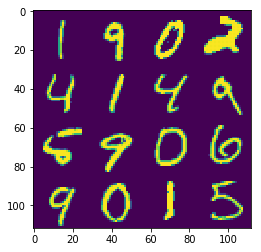

---------------
Reconstructed Images


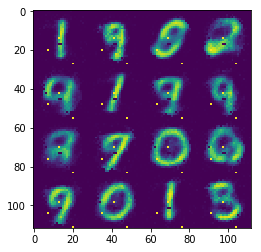

0.041177783

In [59]:
# ks = (5, 10, 20, 100, 200, 500)
AutoEncoderNN(
    mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[100, 20],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()

# of neurons in each layer: [10, 500]
Step 1: Minibatch Loss: 0.336014
Step 5000: Minibatch Loss: 0.056867
Step 10000: Minibatch Loss: 0.053431
Step 15000: Minibatch Loss: 0.053039
Step 20000: Minibatch Loss: 0.050265
Step 25000: Minibatch Loss: 0.049571
Step 30000: Minibatch Loss: 0.047656
---------------
Original Images


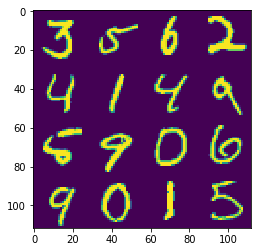

---------------
Reconstructed Images


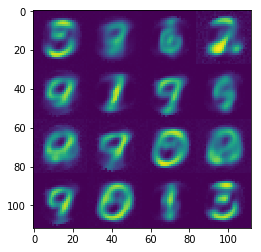

0.047655728

In [60]:
AutoEncoderNN(
    mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[10, 500],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()

# of neurons in each layer: [200, 5]
Step 1: Minibatch Loss: 0.426183
Step 5000: Minibatch Loss: 0.149334
Step 10000: Minibatch Loss: 0.133661
Step 15000: Minibatch Loss: 0.124068
Step 20000: Minibatch Loss: 0.111839
Step 25000: Minibatch Loss: 0.109317
Step 30000: Minibatch Loss: 0.100751
---------------
Original Images


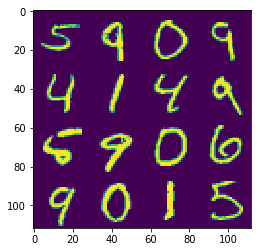

---------------
Reconstructed Images


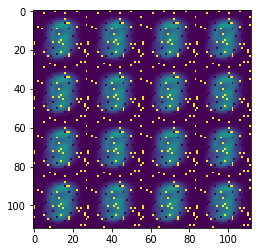

0.10075055

In [61]:
AutoEncoderNN(
    mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[200, 5],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()

# 20 News Groups

In [94]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
ngtrain = fetch_20newsgroups(subset='train', data_home='../Data')
ngtest = fetch_20newsgroups(subset='test', data_home='../Data')
ngtrain_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
_ngtrain_vectors = ngtrain_vectorizer.fit_transform(ngtrain.data)
ngtest_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
_ngtest_vectors = ngtest_vectorizer.fit_transform(ngtest.data)

# remove features in test that are not found in train
one_hot_encode = lambda n_classes, target: np.eye(n_classes)[target]
get_indices = lambda x, y: list(set(np.searchsorted(x, y)))

common_features = np.intersect1d(ngtrain_vectorizer.get_feature_names(), ngtest_vectorizer.get_feature_names())
ngtrain_X = _ngtrain_vectors[:, get_indices(ngtrain_vectorizer.get_feature_names(), common_features)].todense()
ngtest_X = _ngtest_vectors[:, get_indices(ngtest_vectorizer.get_feature_names(), common_features)].todense()
ngtrain_Y = one_hot_encode(20, ngtrain.target)
ngtest_Y = one_hot_encode(20, ngtest.target)

print(ngtrain_X.shape, ngtrain_Y.shape, ngtest_X.shape, ngtest_Y.shape)
print(type(ngtrain_X), type(ngtrain_Y), type(ngtest_X), type(ngtest_Y))

(11314, 49601) (11314, 20) (7532, 49601) (7532, 20)
<class 'numpy.matrixlib.defmatrix.matrix'> <class 'numpy.ndarray'> <class 'numpy.matrixlib.defmatrix.matrix'> <class 'numpy.ndarray'>


In [96]:
AutoEncoderNN(
    ngtrain_X, ngtrain_Y, ngtest_X, ngtest_Y,
    learning_rate=0.001, n_iterations=1000, display_step=100, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[100, 20],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [100, 20]
Step 1: Minibatch Loss: 0.440662
Step 100: Minibatch Loss: 0.440619
Step 200: Minibatch Loss: 0.430949
Step 300: Minibatch Loss: 0.363912
Step 400: Minibatch Loss: 0.309958
Step 500: Minibatch Loss: 0.276520
Step 600: Minibatch Loss: 0.254022
Step 700: Minibatch Loss: 0.238090
Step 800: Minibatch Loss: 0.226222
Step 900: Minibatch Loss: 0.216608
Step 1000: Minibatch Loss: 0.208634
(4, 49601) (4, 49601)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[[1.90520044e-10 3.32152778e-10 3.33424149e-10 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[1.89042448e-10 3.31095817e-10 3.35759254e-10 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[1.88309021e-10 3.30877381e-10 3.37242512e-10 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[1.81727883e-10 3.27931987e-10 3.38359757e-10 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
(

0.20863393

In [97]:
AutoEncoderNN(
    ngtrain_X, ngtrain_Y, ngtest_X, ngtest_Y,
    learning_rate=0.001, n_iterations=1000, display_step=100, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[10, 500],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [10, 500]
Step 1: Minibatch Loss: 0.361288
Step 100: Minibatch Loss: 0.357666
Step 200: Minibatch Loss: 0.345911
Step 300: Minibatch Loss: 0.317717
Step 400: Minibatch Loss: 0.292324
Step 500: Minibatch Loss: 0.277042
Step 600: Minibatch Loss: 0.262446
Step 700: Minibatch Loss: 0.248395
Step 800: Minibatch Loss: 0.234801
Step 900: Minibatch Loss: 0.221617
Step 1000: Minibatch Loss: 0.208997
(4, 49601) (4, 49601)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[[0.00250858 0.00293157 0.00350248 ... 0.99693334 0.99759185 0.99929905]]
---------------
[[5.98077060e-04 2.58546951e-03 3.20942583e-03 ... 9.96680140e-01
  9.97385919e-01 9.99224901e-01]]
---------------
[[0.0024361  0.00271765 0.00330895 ... 0.99714667 0.99776852 0.99935871]]
---------------
[[0.00262629 0.0029208  0.00326444 ... 0.99658608 0.99729615 0.99920064]]
(4, 49601) (4, 49601)
Absolute difference between original and reconstructed va

0.20899652

In [98]:
AutoEncoderNN(
    ngtrain_X, ngtrain_Y, ngtest_X, ngtest_Y,
    learning_rate=0.001, n_iterations=1000, display_step=100, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[200, 5],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [200, 5]
Step 1: Minibatch Loss: 0.453789
Step 100: Minibatch Loss: 0.453758
Step 200: Minibatch Loss: 0.443536
Step 300: Minibatch Loss: 0.361779
Step 400: Minibatch Loss: 0.320458
Step 500: Minibatch Loss: 0.297788
Step 600: Minibatch Loss: 0.284092
Step 700: Minibatch Loss: 0.273985
Step 800: Minibatch Loss: 0.265911
Step 900: Minibatch Loss: 0.259254
Step 1000: Minibatch Loss: 0.254092
(4, 49601) (4, 49601)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[[7.18088476e-18 2.75878128e-16 5.63653998e-16 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[7.17436741e-18 2.74362654e-16 5.64340307e-16 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[7.16821319e-18 2.74755439e-16 5.63798100e-16 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
---------------
[[7.16416662e-18 2.75080541e-16 5.63443352e-16 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
(4

0.2540924

# Spambase

In [99]:
with open('../Data/spambase.data') as f:
    spam_data = []
    target = []
    for line in f.readlines():
        target.append(int(line[-2]))
        line = line[:-3].strip().split(',')
        spam_data.append(list(map(float, line)))
    target = np.array(target)

with open('../Data/spambase.names') as f:
    names = []
    for line in f.readlines()[33:]:
        names.append(line.strip().split(':')[0])
        
spam_data = np.array(spam_data)
spamtrain_X, spamtest_X, spamtrain_Y, spamtest_Y = train_test_split(spam_data, target, random_state = 123, test_size = 0.3)
spamtrain_Y = spamtrain_Y.reshape(-1, 1)
spamtest_Y = spamtest_Y.reshape(-1, 1)
print(spamtrain_X.shape, spamtest_X.shape, spamtrain_Y.shape, spamtest_Y.shape)

(3220, 57) (1381, 57) (3220, 1) (1381, 1)


In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
spamtrain_X = scaler.fit_transform(spamtrain_X)
spamtest_X = scaler.transform(spamtest_X)

In [91]:
AutoEncoderNN(
    spamtrain_X, spamtrain_Y, spamtest_X, spamtest_Y,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[100, 20],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [100, 20]
Step 1: Minibatch Loss: 1.667657
Step 5000: Minibatch Loss: 0.697558
Step 10000: Minibatch Loss: 0.626871
Step 15000: Minibatch Loss: 0.866369
Step 20000: Minibatch Loss: 0.680153
Step 25000: Minibatch Loss: 0.623073
Step 30000: Minibatch Loss: 0.865305
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[3.35583754 2.69759716 2.50218799 2.41204857 1.82555154]
---------------
[3.58737917 2.3762637  1.37471067 1.36702071 1.04076401]
---------------
[1.98024732 1.3451064  1.18286748 0.84025175 0.67848255]
---------------
[2.26067513 2.07467491 0.56030311 0.47888983 0.47028259]
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[4.07529677 3.95700482 2.68343564 0.93419    0.74420974]
---------------
[2.60613919 1.12726892 0.83969869 0.58036499 0.56030302]
---------------
[6.59787545 5.60366044 2.79749286 1.2541

0.86530465

In [101]:
AutoEncoderNN(
    spamtrain_X, spamtrain_Y, spamtest_X, spamtest_Y,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[10, 500],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [10, 500]
Step 1: Minibatch Loss: 1.471294
Step 5000: Minibatch Loss: 0.752305
Step 10000: Minibatch Loss: 0.651736
Step 15000: Minibatch Loss: 0.913623
Step 20000: Minibatch Loss: 0.702856
Step 25000: Minibatch Loss: 0.631858
Step 30000: Minibatch Loss: 0.896887
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[2.28912268 1.08863871 1.07926614 0.54673156 0.49999748]
---------------
[4.74727258 3.10920118 1.62665843 1.20755375 1.02312204]
---------------
[3.4445875  1.93281738 1.070805   0.84926057 0.81600946]
---------------
[0.93321741 0.67857966 0.64681567 0.56112133 0.47902434]
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[4.84190601 3.68285229 3.37604496 1.13324601 1.04085665]
---------------
[1.60791634 1.4061214  1.19224723 0.94911016 0.70671768]
---------------
[7.49923404 6.37941175 2.793726   1.2542

0.896887

In [102]:
AutoEncoderNN(
    spamtrain_X, spamtrain_Y, spamtest_X, spamtest_Y,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[200, 5],
    activation=tf.nn.sigmoid
).optimize()

# of neurons in each layer: [200, 5]
Step 1: Minibatch Loss: 1.580143
Step 5000: Minibatch Loss: 0.772002
Step 10000: Minibatch Loss: 0.678561
Step 15000: Minibatch Loss: 0.941207
Step 20000: Minibatch Loss: 0.739541
Step 25000: Minibatch Loss: 0.673983
Step 30000: Minibatch Loss: 0.937587
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[1.14290882 0.67847771 0.52301618 0.40534201 0.39995464]
---------------
[2.38422534 1.56829032 1.09033351 0.93278088 0.68743716]
---------------
[5.17418924 2.78084764 1.66465556 1.49670088 1.47516673]
---------------
[2.25027369 2.08590529 1.79748094 1.40788858 1.10952706]
(4, 57) (4, 57)
Absolute difference between original and reconstructed values (sorted in decreasing order)
---------------
[4.92020507 4.07723978 3.62952009 1.67857884 0.93278088]
---------------
[2.60613959 1.406148   1.20033491 0.97844375 0.84572644]
---------------
[7.59787545 5.38015846 2.79775169 1.29913

0.9375867

# Fashion

In [92]:
fashion = mnist_data.read_data_sets('../Data/Fashion/', one_hot=True)
print(fashion.train.images.shape, fashion.train.labels.shape, fashion.test.images.shape, fashion.test.labels.shape)

Extracting ../Data/Fashion/train-images-idx3-ubyte.gz
Extracting ../Data/Fashion/train-labels-idx1-ubyte.gz
Extracting ../Data/Fashion/t10k-images-idx3-ubyte.gz
Extracting ../Data/Fashion/t10k-labels-idx1-ubyte.gz
(55000, 784) (55000, 10) (10000, 784) (10000, 10)


# of neurons in each layer: [100, 20]
Step 1: Minibatch Loss: 0.367840
Step 5000: Minibatch Loss: 0.064332
Step 10000: Minibatch Loss: 0.051367
Step 15000: Minibatch Loss: 0.041905
Step 20000: Minibatch Loss: 0.040239
Step 25000: Minibatch Loss: 0.035842
Step 30000: Minibatch Loss: 0.033272
---------------
Original Images


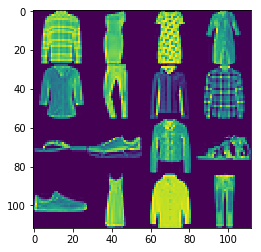

---------------
Reconstructed Images


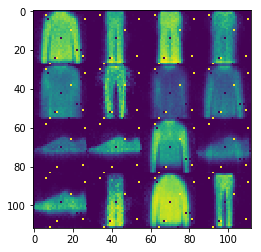

0.033272028

In [93]:
AutoEncoderNN(
    fashion.train.images, fashion.train.labels, fashion.test.images, fashion.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[100, 20],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()

# of neurons in each layer: [10, 500]
Step 1: Minibatch Loss: 0.281040
Step 5000: Minibatch Loss: 0.052059
Step 10000: Minibatch Loss: 0.044482
Step 15000: Minibatch Loss: 0.040019
Step 20000: Minibatch Loss: 0.038886
Step 25000: Minibatch Loss: 0.035795
Step 30000: Minibatch Loss: 0.035054
---------------
Original Images


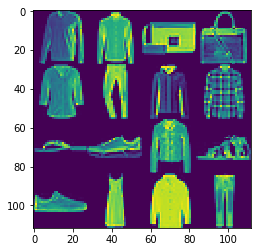

---------------
Reconstructed Images


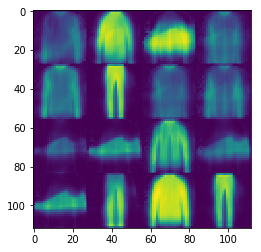

0.035053674

In [103]:
AutoEncoderNN(
    fashion.train.images, fashion.train.labels, fashion.test.images, fashion.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[10, 500],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()

# of neurons in each layer: [200, 5]
Step 1: Minibatch Loss: 0.370008
Step 5000: Minibatch Loss: 0.141520
Step 10000: Minibatch Loss: 0.129566
Step 15000: Minibatch Loss: 0.122502
Step 20000: Minibatch Loss: 0.119518
Step 25000: Minibatch Loss: 0.113689
Step 30000: Minibatch Loss: 0.109770
---------------
Original Images


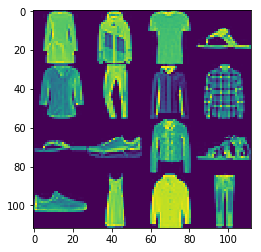

---------------
Reconstructed Images


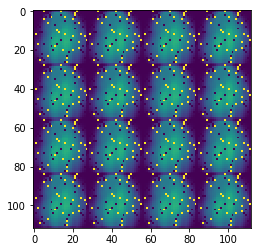

0.10977017

In [104]:
AutoEncoderNN(
    fashion.train.images, fashion.train.labels, fashion.test.images, fashion.test.labels,
    learning_rate=0.001, n_iterations=30000, display_step=5000, batch_size=256,
    n_hidden_layers=2, n_nodes_per_layer=[200, 5],
    activation=tf.nn.sigmoid, image_dataset = True
).optimize()